In [1]:
import numpy as np
import pprint as pp
import matplotlib.pyplot as plt

import time
#import pylab as plt
from IPython import display

In [2]:
#parameters
D_1 = 4.6e22 #N meters, week plate
D_2 = 3.7e23 #N meters, strong plate
#density of sediment
rho_s = 3000 #kg/m3
rho_w = 1000 #kg/m3
rho_m = 3300 #kg/m3
g = 9.8 #ms-2
h_s = 2000 #meters, load thickness

a_1 = (4*D_1/( g * (rho_m - rho_w)))**0.25 #flexural parameter alpha
a_2 = (4*D_2/( g * (rho_m - rho_w)))**0.25

#a_1 = 55000#(4*D_1/(rho_s*g - rho_w*g))**0.25 #flexural parameter alpha
#a_2 = 93000#(4*D_2/(rho_s*g - rho_w*g))**0.25


# Define functions to calculate point flexure at a location:

In [3]:
def Right_Load(a_1,a_2,D_1,D_2,V_0, y, X_y_fliped, X_flip, contact_fliped):
    """this function calculates the flexure due to a force V_0 at y, where y is to the 
    right (positive sign) of a rigidity contrast. Aurgument y must be negative.
    """
    ##switch sighn and solve using the same method as a left hand problem:
    y = -y
    
    M = np.zeros( (8,8) )
           
    #all boundary conditions are the same as if y<0 but D_1, a_1 and D_2, a_2 are switched
    #add BC1: 
    M[0,0] = 1
    M[0,2] = -1
    M[0,4] = -1
    
    #add BC2:
    M[1,2] = np.exp(y / a_2) * np.cos(-y/a_2)
    M[1,3] = np.exp(y / a_2) * np.sin(-y/a_2)
    M[1,4] = np.exp(-y / a_2) * np.cos(-y/a_2)
    M[1,5] = np.exp(-y / a_2) * np.sin(-y/a_2)
    M[1,6] = -1
    
    #add BC3:
    M[2,0] = 1/a_2
    M[2,1] = 1/a_2
    M[2,2] = 1/a_2
    M[2,3] = -1/a_2
    M[2,4] = -1/a_2
    M[2,5] = -1/a_2
    
    #add BC4:
    M[3,2] = -1/a_2*np.exp(y / a_2) *( np.cos(-y/a_2)+ np.sin(-y/a_2) )
    M[3,3] = 1/a_2*np.exp(y / a_2) *( np.cos(-y/a_2)- np.sin(-y/a_2) )
    M[3,4] = 1/a_2*np.exp(-y / a_2) *( np.cos(-y/a_2)- np.sin(-y/a_2) )
    M[3,5] = 1/a_2*np.exp(-y / a_2) *( np.cos(-y/a_2)+ np.sin(-y/a_2) )
    M[3,6] = 1/a_1
    M[3,7] = -1/a_1
    
    #add BC5:
    M[4,1] = D_2*2/(a_2**2)
    M[4,3] = D_2*2/(a_2**2)
    M[4,5] = D_2*-2/(a_2**2)
            
    #add BC6:
    M[5,2] = D_2*2/(a_2**2)*np.exp(y / a_2)*np.sin(-y / a_2)
    M[5,3] = D_2*-2/(a_2**2)*np.exp(y / a_2)*np.cos(-y / a_2)
    M[5,4] = D_2*-2/(a_2**2)*np.exp(-y / a_2)*np.sin(-y / a_2)
    M[5,5] = D_2*2/(a_2**2)*np.exp(-y / a_2)*np.cos(-y / a_2)
    M[5,7] = D_1*2/(a_1**2)
    
    #add BC7:
    M[6,2] = D_2*2/(a_2**3)*np.exp(y / a_2)*(np.cos(-y / a_2) - np.sin(-y / a_2))
    M[6,3] = D_2*2/(a_2**3)*np.exp(y / a_2)*(np.cos(-y / a_2) + np.sin(-y / a_2))
    M[6,4] = -D_2*2/(a_2**3)*np.exp(-y / a_2)*(np.cos(-y / a_2) + np.sin(-y / a_2))
    M[6,5] = D_2*2/(a_2**3)*np.exp(-y / a_2)*(np.cos(-y / a_2) - np.sin(-y / a_2))
    M[6,6] = -2*D_1/(a_1**3)
    M[6,7] = -2*D_1/(a_1**3)
    
    #add BC8:
    M[7,0] = -2*D_2/(a_2**3)    
    M[7,1] = 2*D_2/(a_2**3)
    M[7,2] = -2*D_2/(a_2**3)
    
    
    M[7,3] = -2*D_2/(a_2**3)
    M[7,4] = 2*D_2/(a_2**3)    
    M[7,5] = -2*D_2/(a_2**3)

    m = np.zeros(8)
    m[7] = -V_0    

    #solve the similtaneous equations, gives parameters:    
    a = np.linalg.solve(M,m)

    A1 = a[0]
    A2 = a[1]
    B1 = a[2]
    B2 = a[3]
    B3 = a[4]
    B4 = a[5]
    C1 = a[6]    
    C2 = a[7]
    
    #for x < y
    x_1 = X_flip[0: int(X_y_fliped) ]
    
    #for x > y, x < 0:            
    x_2 = X_flip[int(X_y_fliped):int(contact_fliped)]
    
    #for x > 0
    x_3 = X_flip[int(contact_fliped):]
    
    #solve flexure equations for (x < y), (x > y, x < 0) and (x > 0) respectively:
    w_1 = np.exp((x_1-y) / a_2)*(A1*np.cos((x_1-y)/a_2)+A2*np.sin((x_1-y)/a_2))

    w_2 = (np.exp((y-x_2) / a_2)*(B1*np.cos((x_2-y)/a_2)+B2*np.sin((x_2-y)/a_2)) +
           np.exp((x_2-y) / a_2)*(B3*np.cos((x_2-y)/a_2)+B4*np.sin((x_2-y)/a_2)))

    w_3 = np.exp((-x_3) / a_1)*(C1*np.cos((x_3)/a_1)+C2*np.sin((x_3)/a_1))
    
    #connect flecture curves
    W = np.append(w_1,w_2)
    W_right_wrong = np.append(W,w_3)
    
    #flip the resulting fake left-flexure which will be the actual flexure due to a right hand weight
    W_right = np.flip(W_right_wrong,0)
    
    return -W_right 

In [4]:
def Left_Load(a_1,a_2,D_1,D_2,V_0, y, X_y, X, contact):
    """this function calculates the flexure due to a force V_0 at y, where y is to the 
    left (negative sign) of a rigidity contrast.
    """
    M = np.zeros( (8,8) )

    #BC1:
    M[0,0] = 1
    M[0,2] = -1
    M[0,4] = -1

    #BC2:
    M[1,2] = np.exp(y / a_1) * np.cos(-y/a_1)
    M[1,3] = np.exp(y / a_1) * np.sin(-y/a_1)
    M[1,4] = np.exp(-y / a_1) * np.cos(-y/a_1)
    M[1,5] = np.exp(-y / a_1) * np.sin(-y/a_1)
    M[1,6] = -1

    #BC3:
    M[2,0] = 1/a_1
    M[2,1] = 1/a_1
    M[2,2] = 1/a_1
    M[2,3] = -1/a_1
    M[2,4] = -1/a_1
    M[2,5] = -1/a_1

    #BC4:
    M[3,2] = -1/a_1*np.exp(y / a_1) *( np.cos(-y/a_1)+ np.sin(-y/a_1) )
    M[3,3] = 1/a_1*np.exp(y / a_1) *( np.cos(-y/a_1)- np.sin(-y/a_1) )
    M[3,4] = 1/a_1*np.exp(-y / a_1) *( np.cos(-y/a_1)- np.sin(-y/a_1) )
    M[3,5] = 1/a_1*np.exp(-y / a_1) *( np.cos(-y/a_1)+ np.sin(-y/a_1) )
    M[3,6] = 1/a_2
    M[3,7] = -1/a_2

    #BC5:
    M[4,1] = D_1*2/(a_1**2)
    M[4,3] = D_1*2/(a_1**2)
    M[4,5] = D_1*-2/(a_1**2)    
    
    #BC6:
    M[5,2] = D_1*2/(a_1**2)*np.exp(y / a_1)*np.sin(-y / a_1)
    M[5,3] = D_1*-2/(a_1**2)*np.exp(y / a_1)*np.cos(-y / a_1)
    M[5,4] = D_1*-2/(a_1**2)*np.exp(-y / a_1)*np.sin(-y / a_1)
    M[5,5] = D_1*2/(a_1**2)*np.exp(-y / a_1)*np.cos(-y / a_1)
    M[5,7] = D_2*2/(a_2**2)
    
    #BC7:
    M[6,2] = D_1*2/(a_1**3)*np.exp(y / a_1)*(np.cos(-y / a_1) - np.sin(-y / a_1))
    M[6,3] = D_1*2/(a_1**3)*np.exp(y / a_1)*(np.cos(-y / a_1) + np.sin(-y / a_1))
    M[6,4] = -D_1*2/(a_1**3)*np.exp(-y / a_1)*(np.cos(-y / a_1) + np.sin(-y / a_1))
    M[6,5] = D_1*2/(a_1**3)*np.exp(-y / a_1)*(np.cos(-y / a_1) - np.sin(-y / a_1))
    M[6,6] = -2*D_2/(a_2**3)
    M[6,7] = -2*D_2/(a_2**3)
    
    #BC8:
    M[7,0] = -2*D_1/(a_1**3)
    M[7,1] = 2*D_1/(a_1**3)
    M[7,2] = -2*D_1/(a_1**3)
    M[7,3] = -2*D_1/(a_1**3)
    M[7,4] = 2*D_1/(a_1**3)
    M[7,5] = -2*D_1/(a_1**3)
    
    #Right hand side of the simultaneous equations, with the 8th element = -V_0:
    m = m = np.zeros(8)
    m[7] = -V_0
    #solve the matrix equation:
    
    a = np.linalg.solve(M,m)
    A1 = a[0]
    A2 = a[1]
    B1 = a[2]
    B2 = a[3]
    B3 = a[4]
    B4 = a[5]
    C1 = a[6]
    C2 = a[7]
    
    x_1 = X[0:int(X_y)]
    
    #for x > y, x < 0:
    x_2 = X[int(X_y):int(contact)]
    
    #for x > 0
    x_3 = X[int(contact):]
    
    
    
    #solve the flexure for the 3 sections x_1, x_2 and x_3 respectively:
    w_1 = np.exp((x_1-y) / a_1)*(A1*np.cos((x_1-y)/a_1)+A2*np.sin((x_1-y)/a_1))

    w_2 = (np.exp((y-x_2) / a_1)*(B1*np.cos((x_2-y)/a_1)+B2*np.sin((x_2-y)/a_1)) +
           np.exp((x_2-y) / a_1)*(B3*np.cos((x_2-y)/a_1)+B4*np.sin((x_2-y)/a_1)))    
    
    w_3 = np.exp((-x_3) / a_2)*(C1*np.cos((x_3)/a_2)+C2*np.sin((x_3)/a_2))

    
    W_left = np.append(w_1,w_2)
    W_left = np.append(W_left,w_3)
    
    return -W_left

In [5]:
def Central_Load(a_1,a_2,D_1,D_2,V_0, X, contact):
    """this function calculates the flexure due to a force V_0 at y, where y is 
    on the rigidity contrast. the intiger contact must be defined,
    """
    """extra = 400000    
    X = np.linspace( -extra, extra, (2*extra) + 1)
    contact =  extra #the index s.t. X[contact] = 0 """
    
    M = np.zeros((4,4))
    
    #BC1:
    M[0,0] = 1
    M[0,2] = -1
    
    #BC2:
    M[1,0] = 1/a_1
    M[1,1] = 1/a_1
    M[1,2] = 1/a_2
    M[1,3] = -1/a_2
    
    #BC3:
    M[2,1] = 2*D_1/(a_1**2)
    M[2,3] = 2*D_2/(a_2**2)
    
    #BC4:
    M[3,0] = -2*D_1/(a_1**3)
    M[3,1] = 2*D_1/(a_1**3)
    M[3,2] = -2*D_2/(a_2**3)
    M[3,3] = -2*D_2/(a_2**3)
    
    #create RHS of the boundary conditions:
    m = np.zeros(4)
    m[3] = -V_0
    
    #solve the matrix equation Ma = m:
    a = np.linalg.solve(M,m)
    
    A1 = a[0]
    A2 = a[1]
    C1 = a[2]
    C2 = a[3]
    
    x_1 = X[0:int(contact)]
    x_2 = X[int(contact):]
    
    w_1 = np.exp((x_1) / a_1)*(A1*np.cos(x_1/a_1)+A2*np.sin(x_1/a_1))
    
    w_2 = np.exp((-x_2) / a_2)*(C1*np.cos(x_2/a_2)+C2*np.sin(x_2/a_2))
    
    W_centre = np.append(w_1,w_2)
    
    return -W_centre

# Main function:

In [6]:
def Plate_Flexure(a_1,a_2,D_1,D_2,Force, points_of_weight, contact):
    """'a_1, D_1 and a_2, D_2 are for left and right of the contrast respectively.
    Force is the load in array form, points of weight are the locations of the load from left, 
    contact is the location of the flexural regidity change from the Left.
    """
    #Make array of y elements, distance from the flexural contrast (left is negative, right is positive):
    Y = -np.subtract(contact, points_of_weight)
    
    
    extra_L = contact
    extra_R = 600000 - contact
    X = np.arange(- extra_L , extra_R +1 , 1) #+ add 1 on the right side so to include the element extra_R
        
    #for the Right hand load the flexure will be solved by effectively flipping the geometry around the contact,
    #but the arrays must be the same shape so that the point flexures can be summed together. 
    ##create a flipped X array:
    
    X_flip = -np.flip(X,0)
    #X_flip = -np.arange(- extra_R, extra_L, 1)
    
    contact_fliped = extra_R   #distance from right to left most
    
    #create array to add flexures from each point force into:
    Total_flexure = np.zeros(len(X))
    
    for i in range(0,len(Y)):
        """y needs to be the distance from the contact (right is +), V_0 is the size of force,
        X_y is s.t. X[X_y] = the position of the force."""
        y = Y[i] 
        V_0 = Force[i]
        X_y = extra_L + y
        
        if V_0 == 0:
            pass
        
        elif y < 0:
            """needs to input V_0 = weight, y = distance from contact(m), X_y = indic of y in X, X = space array
            contact - indic of contact"""
            
            w_y = Left_Load(a_1,a_2,D_1,D_2,V_0, y, X_y, X, contact)
            
        elif y == 0:
            w_y = Central_Load(a_1,a_2,D_1,D_2,V_0, X, contact)
            
        else:
            """this function calculates the flexure due to a force V_0 at y, where y is to the 
            right (positive sign) of a rigidity contrast. The flexure is the same as a left-hand flexure except
            with thecoordinates fliped around the contact, the y fliped and the parameters fliped (so that the
            boundary conditions are satisfied)."""
            y = -y
            X_y_fliped = (extra_R + y)
            
            
            #w_y = Right_Load(a_1,a_2,D_1,D_2,V_0, y, X_y_fliped, X_flip, contact_fliped)
            w_y = Left_Load(a_2,a_1,D_2,D_1,V_0, y, X_y_fliped, X_flip, contact_fliped)
            w_y = np.flip(w_y, 0)
            
        
        Total_flexure = Total_flexure + w_y
        
    
    return [X,Total_flexure, Y]

In [7]:
def Plate_Flexure_MN(a_1,a_2,D_1,D_2,Force, points_of_weight, n_halfWidth):
    """'a_1, D_1 and a_2, D_2 are for left and right of the contrast respectively.
    Force is the load in array form, points of weight are the locations of the load from left, 
    contact is the location of the flexural regidity change from the Left.
    """
    #Make array of y elements, distance from the flexural contrast (left is negative, right is positive):
    Y = -np.subtract(n_halfWidth, points_of_weight)
    
    X = np.arange(- n_halfWidth , n_halfWidth +1 , 1) #+ add 1 on the right side so to include the element extra_R
        
    #for the Right hand load the flexure will be solved by effectively flipping the geometry around the contact,
    #but the arrays must be the same shape so that the point flexures can be summed together. 
    ##create a flipped X array:
    
    X_flip = -np.flip(X,0)
    #X_flip = -np.arange(- extra_R, extra_L, 1)
    
    #create array to add flexures from each point force into:
    Total_flexure = np.zeros(len(X))
    
    for i, y in enumerate(Y):
        """y needs to be the distance from the contact (right is +), V_0 is the size of force,
        X_y is s.t. X[X_y] = the position of the force."""
        V_0 = Force[i]
        X_y = n_halfWidth + y
        
        if V_0 == 0:
            pass
        
        elif y < 0:
            """needs to input V_0 = weight, y = distance from contact(m), X_y = indic of y in X, X = space array
            contact - indic of contact"""
            
            w_y = Left_Load(a_1,a_2,D_1,D_2,V_0, y, X_y, X, n_halfWidth)
            
        elif y == 0:
            w_y = Central_Load(a_1,a_2,D_1,D_2,V_0, X, n_halfWidth)
            
        else:
            """this function calculates the flexure due to a force V_0 at y, where y is to the 
            right (positive sign) of a rigidity contrast. The flexure is the same as a left-hand flexure except
            with thecoordinates fliped around the contact, the y fliped and the parameters fliped (so that the
            boundary conditions are satisfied)."""
            y = -y
            X_y_fliped = (n_halfWidth + y)
            
            
            #w_y = Right_Load(a_1,a_2,D_1,D_2,V_0, y, X_y_fliped, X_flip, contact_fliped)
            w_y = Left_Load(a_2,a_1,D_2,D_1,V_0, y, X_y_fliped, X_flip, n_halfWidth)
            w_y = np.flip(w_y, 0)
            
        
        Total_flexure = Total_flexure + w_y
        
    
    return [X,Total_flexure, Y]

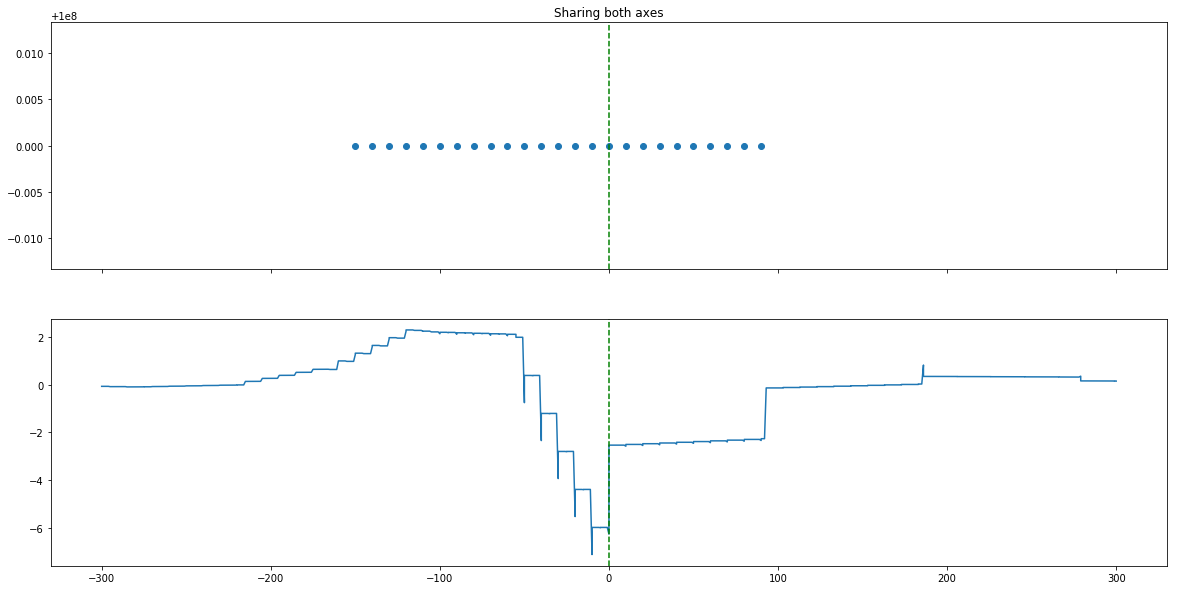

<Figure size 432x288 with 0 Axes>

In [9]:
points = np.arange(150000,400000,10000) #this is an array of locations for the loads
face = 100000000*np.ones(len(points)) #this is an array of weights for the load

ext = Plate_Flexure_MN(55000,93000,4.6e22,3.7e23,face, points, n_halfWidth=300000)

#plot:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, squeeze=True, figsize=(20,10))
plt.figure()
ax2.plot(ext[0]/1000, ext[1])
ax1.set_title('Sharing both axes')
ax1.scatter(ext[2]/1000,face)

ax1.axvline(x=0, linestyle="--", c='g')
ax2.axvline(x=0, linestyle="--", c='g')

plt.show()

# Testing symmetry and functional form of introducing load at Te change

I will compair the solutions for a load on an elastic thikness ($T_e$) change contact  with three different $T_e$, conditions: a constant $T_e$, a contrast with a higher $T_e$ on the left and a contrast with a higher $T_e$ on the right.

In [10]:
D_1 = 4.6e22 #flexural regidity (N meters), weak plate
D_2 = 3.7e23 #flexural regidity (N meters), strong plate

#density of sediment
rho_s = 3000 #kg/m3
rho_w = 1000 #kg/m3
rho_m = 3300 #kg/m3
g = 9.8 #ms-2
h_s = 2000 #meters, load thickness
a_1 = (4*D_1/( g * (rho_m - rho_w)))**0.25 #flexural parameter alpha
a_2 = (4*D_2/( g * (rho_m - rho_w)))**0.25

n_halfWidth = 400000

contact_load = [8.8e12]
load_points = [n_halfWidth]

In [11]:
V_0 = contact_load[0]

constant_rdg_low = Plate_Flexure_MN(a_1, a_1, D_1, D_1, contact_load, load_points, n_halfWidth=n_halfWidth)
x_margin_low = 3*np.pi/4*a_1
x_forebulge_low = np.pi*a_1
w_0_low = V_0*a_1**3/(8*D_1)

constant_rdg_high = Plate_Flexure_MN(a_2, a_2, D_2, D_2, contact_load, load_points, n_halfWidth=n_halfWidth)
x_margin_high = 3*np.pi/4*a_2
x_forebulge_high = np.pi*a_2
w_0_high = V_0*a_2**3/(8*D_2)

high_left = Plate_Flexure_MN(a_2, a_1, D_2, D_1, contact_load, load_points, n_halfWidth=n_halfWidth)

high_right = Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, load_points, n_halfWidth=n_halfWidth)

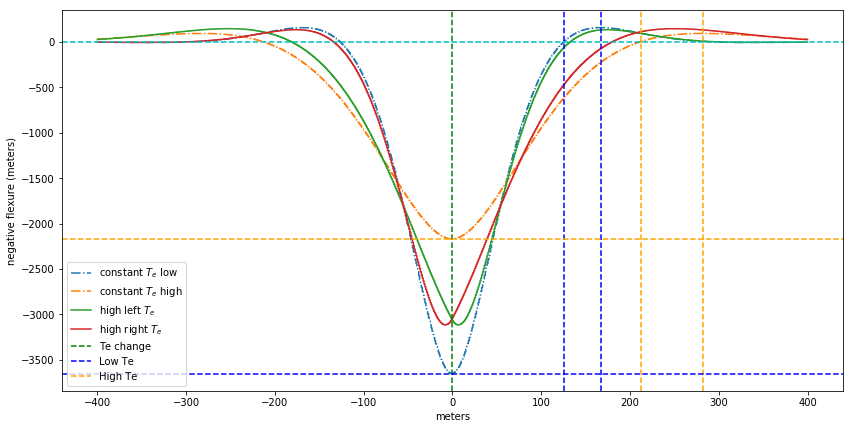

In [12]:
plt.figure(figsize=(14,7))
plt.plot(constant_rdg_low[0]/1000, constant_rdg_low[1], label="constant $T_e$ low", linestyle="-.")
plt.plot(constant_rdg_high[0]/1000, constant_rdg_high[1], label="constant $T_e$ high", linestyle="-.")
plt.plot(high_left[0]/1000, high_left[1], label="high left $T_e$")
plt.plot(high_right[0]/1000, high_right[1], label="high right $T_e$")

plt.axvline(x=0, linestyle="--", c='g', label="Te change")
plt.axvline(x=x_margin_low/1000, linestyle="--", c='b', label="Low Te")
plt.axvline(x=x_margin_high/1000, linestyle="--", c='orange', label="High Te")
plt.axvline(x=x_forebulge_low/1000, linestyle="--", c='b')
plt.axvline(x=x_forebulge_high/1000, linestyle="--", c='orange')

plt.axhline(-w_0_low, linestyle="--", c='b')
plt.axhline(-w_0_high, linestyle="--", c='orange')


plt.axhline(y=0, linestyle="--", c='c')

plt.xlabel("meters")
plt.ylabel("negative flexure (meters)")
plt.legend()

plt.show()

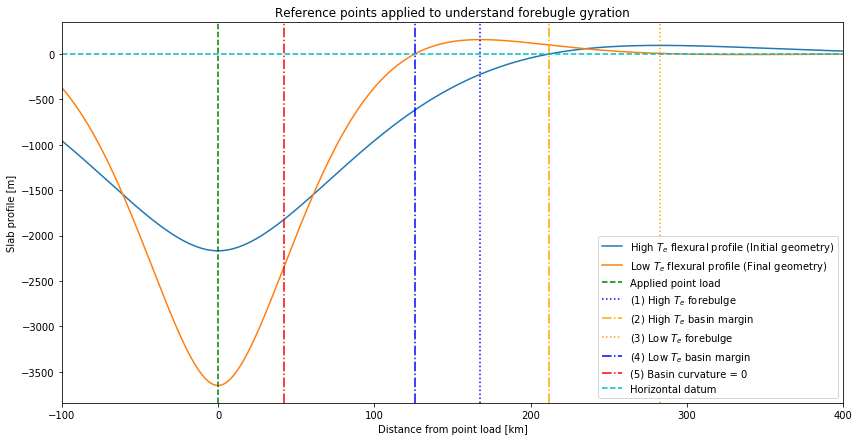

In [191]:
### PAPER FIGURE

plt.figure(figsize=(14,7))
plt.plot(constant_rdg_high[0]/1000, constant_rdg_high[1], label="High $T_e$ flexural profile (Initial geometry)")
plt.plot(constant_rdg_low[0]/1000, constant_rdg_low[1], label="Low $T_e$ flexural profile (Final geometry)")

plt.axvline(x=0, linestyle="--", c='g', label="Applied point load")

plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.", label="(4) Low $T_e$ basin margin")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")

plt.xlim(-100,400)
plt.axhline(y=0, linestyle="--", c='c', label="Horizontal datum")

plt.xlabel("Distance from point load [km]")
plt.ylabel("Slab profile [m]")
plt.title("Reference points applied to understand forebugle gyration")
plt.legend()

plt.show()

## Comparison against online example for line load with infinite plate
http://geofaculty.uwyo.edu/heller/Short%20Course/Basins%205%20Flexure.pdf

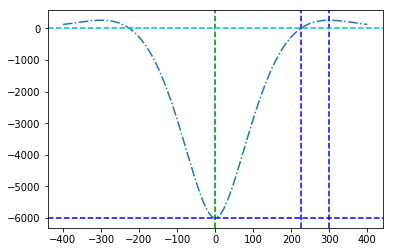

In [12]:
D_1 = 1.6e23 #flexural regidity (N meters), weak plate
a_1 = 95.5e3
V_0 = [8*D_1*6000/a_1**3]

constant_rdg_low = Plate_Flexure_MN(a_1, a_1, D_1, D_1, V_0, load_points, n_halfWidth)
x_margin_low = 3*np.pi/4*a_1
x_forebulge_low = np.pi*a_1
w_0_low = V_0[0]*a_1**3/(8*D_1)

plt.plot(constant_rdg_low[0]/1000, constant_rdg_low[1], label="constant $T_e$ low", linestyle="-.")

plt.axvline(x=0, linestyle="--", c='g', label="Te change")
plt.axvline(x=x_margin_low/1000, linestyle="--", c='b', label="Low Te")
plt.axvline(x=x_forebulge_low/1000, linestyle="--", c='b')

plt.axhline(-w_0_low, linestyle="--", c='b')

plt.axhline(y=0, linestyle="--", c='c')

## Multiple loads

In [13]:
D_1 = 4.6e22 #flexural regidity (N meters), weak plate
D_2 = 3.7e23 #flexural regidity (N meters), strong plate

#density of sediment
rho_s = 3000 #kg/m3
rho_w = 1000 #kg/m3
rho_m = 3300 #kg/m3 
g = 9.8 #ms-2
h_s = 2000 #meters, load thickness
a_1 = (4*D_1/( g * (rho_m - rho_w)))**0.25 #flexural parameter alpha
a_2 = (4*D_2/( g * (rho_m - rho_w)))**0.25

contact_load = np.array( [4.4e12, 4.4e12] )
load_points = np.array( [200000, 400000] )

In [14]:
V_0 = contact_load[0]

constant_rdg_low = Plate_Flexure_MN(a_1, a_1, D_1, D_1, contact_load, load_points, n_halfWidth)
x_margin_low = 3*np.pi/4*a_1
x_forebulge_low = np.pi*a_1
w_0_low = V_0*a_1**3/(8*D_1)

constant_rdg_high = Plate_Flexure_MN(a_2, a_2, D_2, D_2, contact_load, load_points, n_halfWidth)
x_margin_high = 3*np.pi/4*a_2
x_forebulge_high = np.pi*a_2
w_0_high = V_0*a_2**3/(8*D_2)

high_left = Plate_Flexure_MN(a_2, a_1, D_2, D_1, contact_load, load_points, n_halfWidth)

high_right = Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, load_points, n_halfWidth)

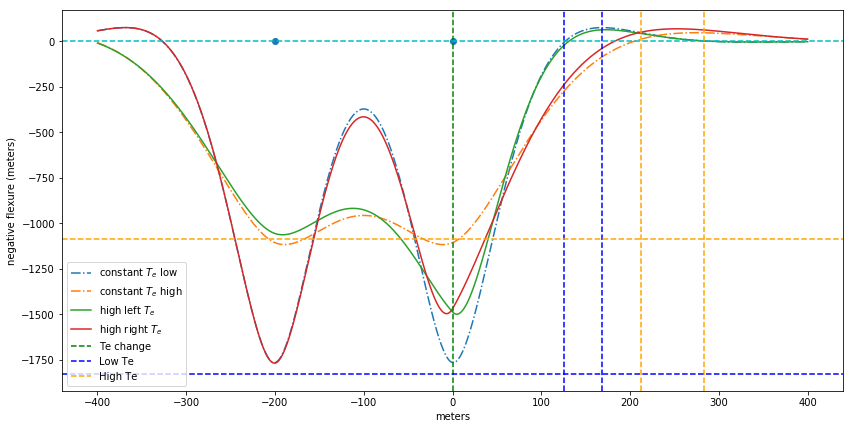

In [15]:
plt.figure(figsize=(14,7))
plt.plot(constant_rdg_low[0]/1000, constant_rdg_low[1], label="constant $T_e$ low", linestyle="-.")
plt.plot(constant_rdg_high[0]/1000, constant_rdg_high[1], label="constant $T_e$ high", linestyle="-.")
plt.plot(high_left[0]/1000, high_left[1], label="high left $T_e$")
plt.plot(high_right[0]/1000, high_right[1], label="high right $T_e$")

plt.axvline(x=0, linestyle="--", c='g', label="Te change")
plt.axvline(x=x_margin_low/1000, linestyle="--", c='b', label="Low Te")
plt.axvline(x=x_margin_high/1000, linestyle="--", c='orange', label="High Te")
plt.axvline(x=x_forebulge_low/1000, linestyle="--", c='b')
plt.axvline(x=x_forebulge_high/1000, linestyle="--", c='orange')

plt.axhline(-w_0_low, linestyle="--", c='b')
plt.axhline(-w_0_high, linestyle="--", c='orange')

plt.scatter((load_points-n_halfWidth)/1000, (load_points*0))


plt.axhline(y=0, linestyle="--", c='c')

plt.xlabel("meters")
plt.ylabel("negative flexure (meters)")
plt.legend()

plt.show()

## Migrating load

In [206]:
D_2 = 4.6e22 #flexural regidity (N meters), weak plate
D_1 = 3.7e23 #flexural regidity (N meters), strong plate

#density of sediment
rho_s = 3000 #kg/m3
rho_w = 1000 #kg/m3
rho_m = 3300 #kg/m3
g = 9.8 #ms-2
h_s = 2000 #meters, load thickness
a_1 = (4*D_1/( g * (rho_m - rho_w)))**0.25 #flexural parameter alpha
a_2 = (4*D_2/( g * (rho_m - rho_w)))**0.25

n_halfWidth = 600000

contact_load = np.array( [8.8e12] )

loadLocations = n_halfWidth + np.arange(-500000, 250000, 1000)
#loadLocations = np.flip(loadLocations, axis=0)

/Users/mnaylor/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:3361: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


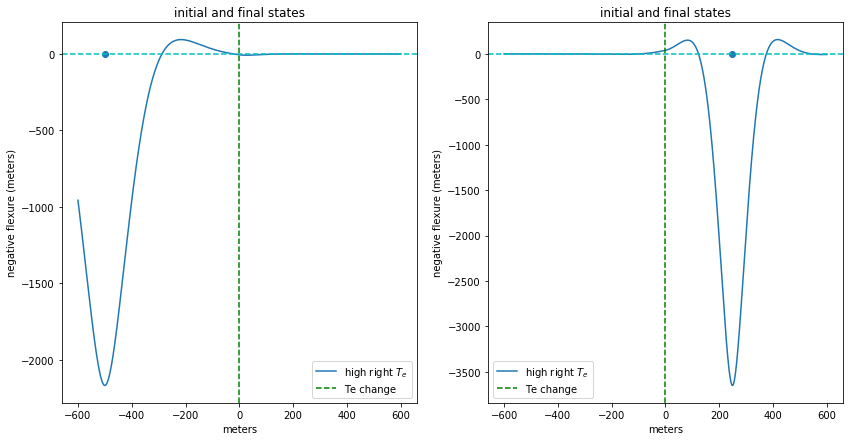

In [207]:
## Endmember figures

plt.figure(figsize=(14,7))

for t, load_points in enumerate(loadLocations[[0,-1]]):
    V_0 = contact_load[0]
    
    n_load = np.array( [load_points] )

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, n_load, n_halfWidth)
    
    plt.subplot(1,2,t+1)

    plt.plot(x/1000, w, label="high right $T_e$", hold=False)

    plt.axvline(x=0, linestyle="--", c='g', label="Te change")

    plt.scatter((load_points-n_halfWidth)/1000, (load_points*0))


    plt.axhline(y=0, linestyle="--", c='c')

    plt.xlabel("meters")
    plt.ylabel("negative flexure (meters)")
    
    plt.title("initial and final states")
    plt.legend()



In [208]:
z_FB = np.empty_like( loadLocations )
z_DF = np.empty_like( loadLocations )
x_FB = np.empty_like( loadLocations )
x_DF = np.empty_like( loadLocations )

basinWidth_DF2FB = np.empty_like( loadLocations )\

makePlot=False

for t, load_points in enumerate(loadLocations):
    V_0 = contact_load[0]
    
    n_load = np.array( [load_points] )

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, n_load, n_halfWidth)
    
    n_FB = n_load + np.argmax( w[ load_points : ] )
    x_FB[t] = x[n_FB]
    x_DF[t] = x[load_points]
    z_FB[t] = w[ n_FB ]
    z_DF[t] = w[load_points]
    basinWidth_DF2FB[t] = x[n_FB] - x[load_points]
    
    if(makePlot):
        plt.figure(figsize=(14,7))
        plt.plot(x/1000, w, label="high right $T_e$", hold=False)

        plt.axvline(x=0, linestyle="--", c='g', label="Te change")

        plt.axhline(z_DF[t], linestyle="--", c='b', hold=True)
        plt.axhline(z_FB[t], linestyle="--", c='orange', hold=True)

        plt.scatter((load_points-n_halfWidth)/1000, (load_points*0), hold=True)


        plt.axhline(y=0, linestyle="--", c='c')

        plt.xlabel("meters")
        plt.ylabel("negative flexure (meters)")
        plt.legend()

        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.01) # necessary to get the plot up.
    

In [204]:
print( D_1)

4.6e+22


In [200]:
print( loadLocations )

[100000 101000 102000 103000 104000 105000 106000 107000 108000 109000
 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000
 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000
 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000
 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000
 150000 151000 152000 153000 154000 155000 156000 157000 158000 159000
 160000 161000 162000 163000 164000 165000 166000 167000 168000 169000
 170000 171000 172000 173000 174000 175000 176000 177000 178000 179000
 180000 181000 182000 183000 184000 185000 186000 187000 188000 189000
 190000 191000 192000 193000 194000 195000 196000 197000 198000 199000
 200000 201000 202000 203000 204000 205000 206000 207000 208000 209000
 210000 211000 212000 213000 214000 215000 216000 217000 218000 219000
 220000 221000 222000 223000 224000 225000 226000 227000 228000 229000
 230000 231000 232000 233000 234000 235000 236000 237000 238000 239000
 24000

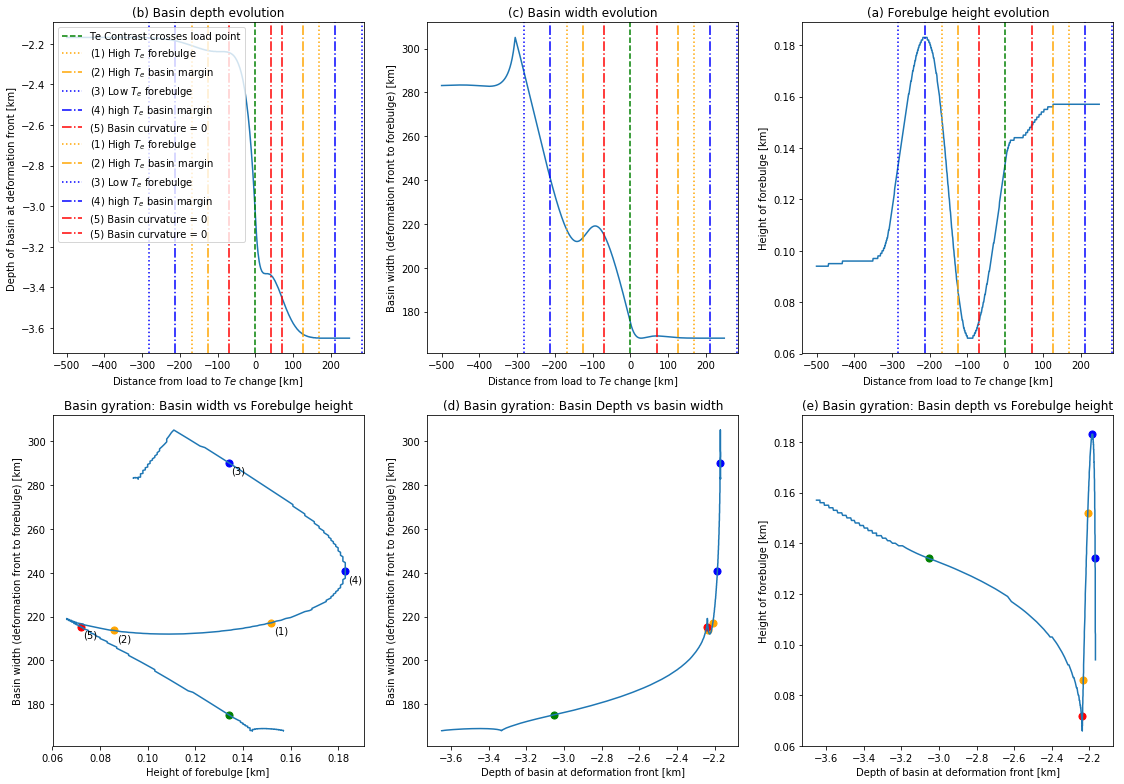

In [209]:
### PAPER FIGURE

plt.figure(figsize=(16,11))

n_TeCrossingDF = (loadLocations-n_halfWidth)==0
x_forebulge_low = np.pi*a_1
x_forebulge_high = np.pi*a_2
x_BM_low = 3*np.pi/4*a_1
x_BM_high = 3*np.pi/4*a_2
x_StressChange_high = np.pi/4*a_2
x_StressChange_low = np.pi/4*a_1

n_forebulge_low = np.argmin( ((loadLocations-n_halfWidth)+x_forebulge_low)**2)
n_forebulge_high = np.argmin( ((loadLocations-n_halfWidth)+x_forebulge_high)**2)
n_BM_low = np.argmin( ((loadLocations-n_halfWidth)+x_BM_low)**2)
n_BM_high = np.argmin( ((loadLocations-n_halfWidth)+x_BM_high)**2)
n_StressChange_high = np.argmin( ((loadLocations-n_halfWidth)+x_StressChange_high)**2)
n_StressChange_low = np.argmin( ((loadLocations-n_halfWidth)+x_StressChange_low)**2)


plt.subplot(2,3,3)
plt.plot((loadLocations-n_halfWidth)/1000., z_FB/1000.)
plt.xlabel("Distance from load to $Te$ change [km]")
plt.ylabel("Height of forebulge [km]")
plt.title("(a) Forebulge height evolution")
plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")
plt.axvline(x=-x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=-x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=-x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=-x_BM_low/1000., c='b', linestyle="-.", label="(4) high $T_e$ basin margin")
plt.axvline(x=-x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")

plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.", label="(4) high $T_e$ basin margin")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")




plt.subplot(2,3,1)
plt.plot((loadLocations-n_halfWidth)/1000., z_DF/1000.)
plt.xlabel("Distance from load to $Te$ change [km]")
plt.ylabel("Depth of basin at deformation front [km]")
plt.title("(b) Basin depth evolution")
plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")
plt.axvline(x=-x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=-x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=-x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=-x_BM_low/1000., c='b', linestyle="-.", label="(4) high $T_e$ basin margin")
plt.axvline(x=-x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")

plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.", label="(4) high $T_e$ basin margin")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")
plt.axvline(x=x_StressChange_high/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")



plt.legend(loc="upper left")

plt.subplot(2,3,2)
plt.plot((loadLocations-n_halfWidth)/1000., basinWidth_DF2FB/1000.)
plt.xlabel("Distance from load to $Te$ change [km]")
plt.ylabel("Basin width (deformation front to forebulge) [km]")
plt.title("(c) Basin width evolution")

plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")
plt.axvline(x=-x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=-x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=-x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=-x_BM_low/1000., c='b', linestyle="-.", label="(4) high $T_e$ basin margin")
plt.axvline(x=-x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")

plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.", label="(4) high $T_e$ basin margin")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")


plt.subplot(2,3,4)
plt.plot( z_FB/1000., basinWidth_DF2FB/1000.)
plt.scatter( z_FB[n_TeCrossingDF]/1000., basinWidth_DF2FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Height of forebulge [km]")
plt.ylabel("Basin width (deformation front to forebulge) [km]")
plt.title("Basin gyration: Basin width vs Forebulge height")

n = ["(1)", "(2)","(3)","(4)","(5)"]
xs = [z_FB[n_forebulge_high]/1000., z_FB[n_BM_high]/1000., z_FB[n_forebulge_low]/1000., z_FB[n_BM_low]/1000., z_FB[n_StressChange_low]/1000. ]
ys = [basinWidth_DF2FB[n_forebulge_high]/1000., basinWidth_DF2FB[n_BM_high]/1000.,basinWidth_DF2FB[n_forebulge_low]/1000., basinWidth_DF2FB[n_BM_low]/1000.,  basinWidth_DF2FB[n_StressChange_low]/1000.]

for i, txt in enumerate(n):
    plt.annotate(txt, (xs[i], ys[i]), xytext=(xs[i]+0.001,ys[i]-5))


plt.scatter(z_FB[n_forebulge_low]/1000., basinWidth_DF2FB[n_forebulge_low]/1000., c="b", s=50)
plt.scatter(z_FB[n_forebulge_high]/1000., basinWidth_DF2FB[n_forebulge_high]/1000., c="orange", s=50)
plt.scatter(z_FB[n_BM_low]/1000., basinWidth_DF2FB[n_BM_low]/1000., c="b", s=50)
plt.scatter(z_FB[n_BM_high]/1000., basinWidth_DF2FB[n_BM_high]/1000., c="orange", s=50)
#plt.scatter(z_FB[n_StressChange_high]/1000., basinWidth_DF2FB[n_StressChange_high]/1000., c="r", s=50)
plt.scatter(z_FB[n_StressChange_low]/1000., basinWidth_DF2FB[n_StressChange_low]/1000., c="r", s=50)


plt.subplot(2,3,5)
plt.plot( z_DF/1000., basinWidth_DF2FB/1000.)
plt.scatter( z_DF[n_TeCrossingDF]/1000., basinWidth_DF2FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Depth of basin at deformation front [km]")
plt.ylabel("Basin width (deformation front to forebulge) [km]")
plt.title("(d) Basin gyration: Basin Depth vs basin width")


plt.scatter(z_DF[n_forebulge_low]/1000., basinWidth_DF2FB[n_forebulge_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_forebulge_high]/1000., basinWidth_DF2FB[n_forebulge_high]/1000., c="orange", s=50)
plt.scatter(z_DF[n_BM_low]/1000., basinWidth_DF2FB[n_BM_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_BM_high]/1000., basinWidth_DF2FB[n_BM_high]/1000., c="orange", s=50)
#plt.scatter(z_FB[n_StressChange_high]/1000., basinWidth_DF2FB[n_StressChange_high]/1000., c="r", s=50)
plt.scatter(z_DF[n_StressChange_low]/1000., basinWidth_DF2FB[n_StressChange_low]/1000., c="r", s=50)



plt.subplot(2,3,6)
plt.plot( z_DF/1000., z_FB/1000.)
plt.scatter( z_DF[n_TeCrossingDF]/1000., z_FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Depth of basin at deformation front [km]")
plt.ylabel("Height of forebulge [km]")
plt.title("(e) Basin gyration: Basin depth vs Forebulge height")


plt.scatter(z_DF[n_forebulge_low]/1000., z_FB[n_forebulge_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_forebulge_high]/1000., z_FB[n_forebulge_high]/1000., c="orange", s=50)
plt.scatter(z_DF[n_BM_low]/1000., z_FB[n_BM_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_BM_high]/1000., z_FB[n_BM_high]/1000., c="orange", s=50)
#plt.scatter(z_FB[n_StressChange_high]/1000., basinWidth_DF2FB[n_StressChange_high]/1000., c="r", s=50)
plt.scatter(z_DF[n_StressChange_low]/1000., z_FB[n_StressChange_low]/1000., c="r", s=50)



plt.tight_layout()


/Users/mnaylor/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:3361: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


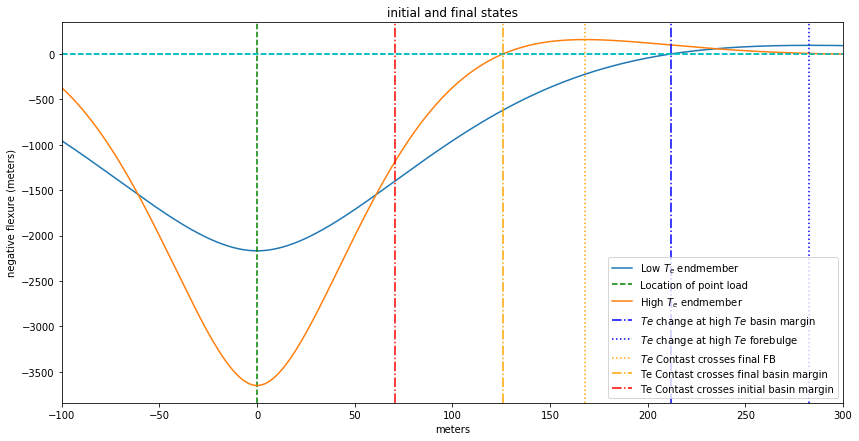

In [210]:
## Endmember figures

plt.figure(figsize=(14,7))

for t, load_points in enumerate(loadLocations[[0,-1]]):
    V_0 = contact_load[0]
    
    n_load = np.array( [load_points] )

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, n_load, n_halfWidth)

    if(t==1):
        plt.plot(x/1000 -(load_points-n_halfWidth)/1000, w, label="High $T_e$ endmember", hold=True)
    else:
        plt.plot(x/1000 -(load_points-n_halfWidth)/1000, w, label="Low $T_e$ endmember", hold=True)
        plt.axvline(x=0, linestyle="--", c='g', label="Location of point load")




    plt.axhline(y=0, linestyle="--", c='c')

    plt.xlabel("meters")
    plt.ylabel("negative flexure (meters)")
    
    plt.title("initial and final states")


plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.", label="$Te$ change at high $Te$ basin margin")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":", label="$Te$ change at high $Te$ forebulge")
plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":", label="$Te$ Contast crosses final FB")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.", label="Te Contast crosses final basin margin")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.", label="Te Contast crosses initial basin margin")

plt.xlim(-100,300)

plt.legend()






/Users/mnaylor/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:3361: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


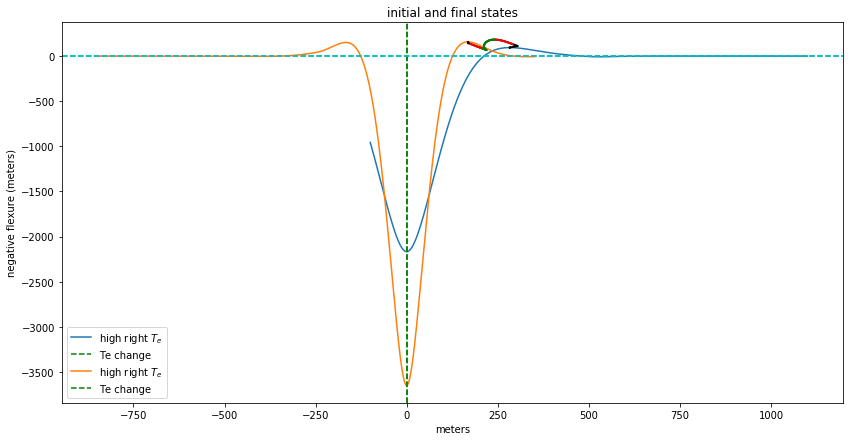

In [211]:
## Endmember figures

plt.figure(figsize=(14,7))

for t, load_points in enumerate(loadLocations[[0,-1]]):
    V_0 = contact_load[0]
    
    n_load = np.array( [load_points] )

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, n_load, n_halfWidth)

    plt.plot(x/1000 -(load_points-n_halfWidth)/1000, w, label="high right $T_e$", hold=True)

    plt.axvline(x=0, linestyle="--", c='g', label="Te change")

    plt.axhline(y=0, linestyle="--", c='c')

    plt.xlabel("meters")
    plt.ylabel("negative flexure (meters)")
    
    plt.title("initial and final states")
    plt.legend()

plt.plot((x_FB-loadLocations+n_halfWidth)/1000.  , z_FB, c="k", linewidth=2)
plt.plot((x_FB[n_forebulge_high:n_forebulge_low]-loadLocations[n_forebulge_high:n_forebulge_low]+n_halfWidth)/1000.  , z_FB[n_forebulge_high:n_forebulge_low], c="b", linewidth=2)
plt.plot((x_FB[n_BM_high:n_forebulge_low]-loadLocations[n_BM_high:n_forebulge_low]+n_halfWidth)/1000.  , z_FB[n_BM_high:n_forebulge_low], c="c", linewidth=2)
plt.plot((x_FB[n_forebulge_low:n_BM_low]-loadLocations[n_forebulge_low:n_BM_low]+n_halfWidth)/1000.  , z_FB[n_forebulge_low:n_BM_low], c="r", linewidth=2)
plt.plot((x_FB[n_BM_low:n_a1]-loadLocations[n_BM_low:n_a1]+n_halfWidth)/1000.  , z_FB[n_BM_low:n_a1], c="g", linewidth=2)
plt.plot((x_FB[n_a1:np.argmax(n_TeCrossingDF)]-loadLocations[n_a1:np.argmax(n_TeCrossingDF)]+n_halfWidth)/1000.  , z_FB[n_a1:np.argmax(n_TeCrossingDF)], c="r", linewidth=2)








/Users/mnaylor/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:3361: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


(-50, 200)

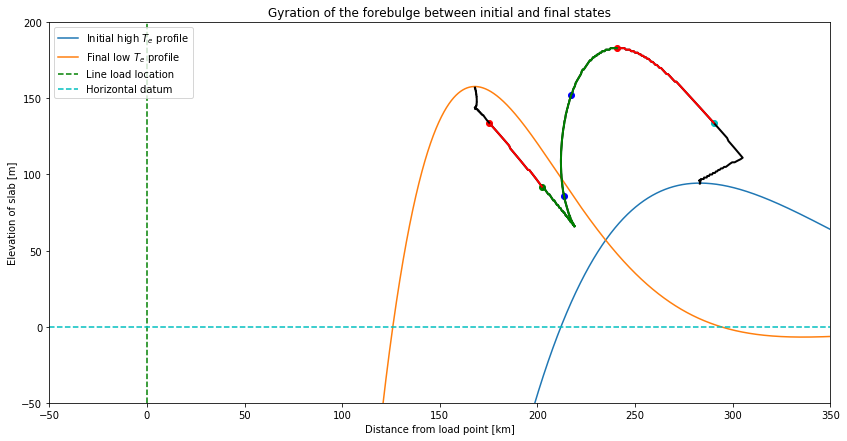

In [213]:
## Endmember figures

plt.figure(figsize=(14,7))

for t, load_points in enumerate(loadLocations[[0,-1]]):
    V_0 = contact_load[0]
    
    n_load = np.array( [load_points] )

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, n_load, n_halfWidth)

    if(t==0):
        plt.plot(x/1000 -(load_points-n_halfWidth)/1000, w, label="Initial high $T_e$ profile", hold=True)
    else:
        plt.plot(x/1000 -(load_points-n_halfWidth)/1000, w, label="Final low $T_e$ profile", hold=True)

plt.axvline(x=0, linestyle="--", c='g', label="Line load location")

plt.axhline(y=0, linestyle="--", c='c', label="Horizontal datum")

plt.xlabel("Distance from load point [km]")
plt.ylabel("Elevation of slab [m]")

plt.title("Gyration of the forebulge between initial and final states")
plt.legend()

plt.plot((x_FB-loadLocations+n_halfWidth)/1000.  , z_FB, c="k", linewidth=2)

plt.plot((x_FB[n_forebulge_high:n_forebulge_low]-loadLocations[n_forebulge_high:n_forebulge_low]+n_halfWidth)/1000.  , z_FB[n_forebulge_high:n_forebulge_low], c="b", linewidth=2)
plt.plot((x_FB[n_BM_high:n_forebulge_low]-loadLocations[n_BM_high:n_forebulge_low]+n_halfWidth)/1000.  , z_FB[n_BM_high:n_forebulge_low], c="c", linewidth=2)
plt.plot((x_FB[n_forebulge_low:n_BM_low]-loadLocations[n_forebulge_low:n_BM_low]+n_halfWidth)/1000.  , z_FB[n_forebulge_low:n_BM_low], c="r", linewidth=2)
plt.plot((x_FB[n_BM_low:n_a1]-loadLocations[n_BM_low:n_a1]+n_halfWidth)/1000.  , z_FB[n_BM_low:n_a1], c="g", linewidth=2)
plt.plot((x_FB[n_a1:np.argmax(n_TeCrossingDF)]-loadLocations[n_a1:np.argmax(n_TeCrossingDF)]+n_halfWidth)/1000.  , z_FB[n_a1:np.argmax(n_TeCrossingDF)], c="r", linewidth=2)

plt.scatter( (x_FB[n_forebulge_high]-loadLocations[n_forebulge_high]+n_halfWidth)/1000.  , z_FB[n_forebulge_high], c="b")
plt.scatter( (x_FB[n_BM_high]-loadLocations[n_BM_high]+n_halfWidth)/1000.  , z_FB[n_BM_high], c="b")
plt.scatter( (x_FB[n_forebulge_low]-loadLocations[n_forebulge_low]+n_halfWidth)/1000.  , z_FB[n_forebulge_low], c="c")
plt.scatter( (x_FB[n_BM_low]-loadLocations[n_BM_low]+n_halfWidth)/1000.  , z_FB[n_BM_low], c="r")
plt.scatter( (x_FB[n_a1]-loadLocations[n_a1]+n_halfWidth)/1000.  , z_FB[n_a1], c="g")
plt.scatter( (x_FB[np.argmax(n_TeCrossingDF)]-loadLocations[np.argmax(n_TeCrossingDF)]+n_halfWidth)/1000.  , z_FB[np.argmax(n_TeCrossingDF)], c="r")

n_BM_high

plt.xlim(-50,350)
plt.ylim(-50,200)






## Second derivative of slab profile

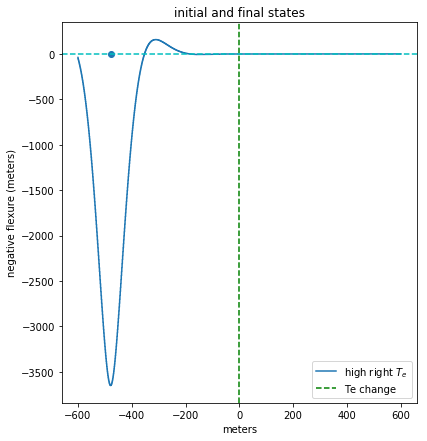

In [21]:
plt.figure(figsize=(14,7))

for t, load_points in enumerate(loadLocations[[22]]):
    V_0 = contact_load[0]
    
    n_load = np.array( [load_points] )

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, n_load, n_halfWidth)
    
    plt.subplot(1,2,t+1)

    plt.plot(x/1000, w, label="high right $T_e$", hold=False)

    plt.axvline(x=0, linestyle="--", c='g', label="Te change")

    plt.scatter((load_points-n_halfWidth)/1000, (load_points*0))


    plt.axhline(y=0, linestyle="--", c='c')

    plt.xlabel("meters")
    plt.ylabel("negative flexure (meters)")
    
    plt.title("initial and final states")
    plt.legend()

In [22]:
sndDeriv_w = (-w[0:-4]+16*w[1:-3]-30*w[2:-2]+16*w[3:-1]-w[4:])/16.

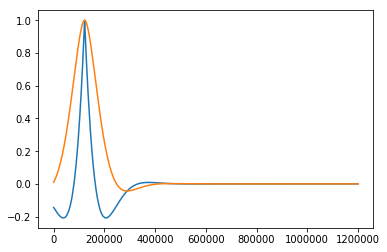

In [23]:
plt.plot(sndDeriv_w/np.max(sndDeriv_w))
plt.plot(w[2:-2]/np.min(w[2:-2]))


# Now with distributed load

In [24]:
D_1 = 4.6e22 #flexural regidity (N meters), weak plate
D_2 = 3.7e23 #flexural regidity (N meters), strong plate

#density of sediment
rho_s = 3000 #kg/m3
rho_w = 1000 #kg/m3
rho_m = 3300 #kg/m3
g = 9.8 #ms-2
h_s = 2000 #meters, load thickness
a_1 = (4*D_1/( g * (rho_m - rho_w)))**0.25 #flexural parameter alpha
a_2 = (4*D_2/( g * (rho_m - rho_w)))**0.25

n_halfWidth = 900000

totalTopographicLoad = 1.5e13
n_loadWidth = 150000

contact_load = np.array( [8.8e12] )
xDF_Right = n_halfWidth + np.arange(-500000, 250000, 25000)
xDF_Left = xDF_Right - n_loadWidth

#loadLocations = np.flip(loadLocations, axis=0)

In [25]:
loadThickness = totalTopographicLoad / ( n_loadWidth * rho_s * g)
print(loadThickness)

3401.36054422


In [26]:
xDF_Right


array([ 400000,  425000,  450000,  475000,  500000,  525000,  550000,
        575000,  600000,  625000,  650000,  675000,  700000,  725000,
        750000,  775000,  800000,  825000,  850000,  875000,  900000,
        925000,  950000,  975000, 1000000, 1025000, 1050000, 1075000,
       1100000, 1125000])

(0, ' / ', 30)
(1, ' / ', 30)
(2, ' / ', 30)


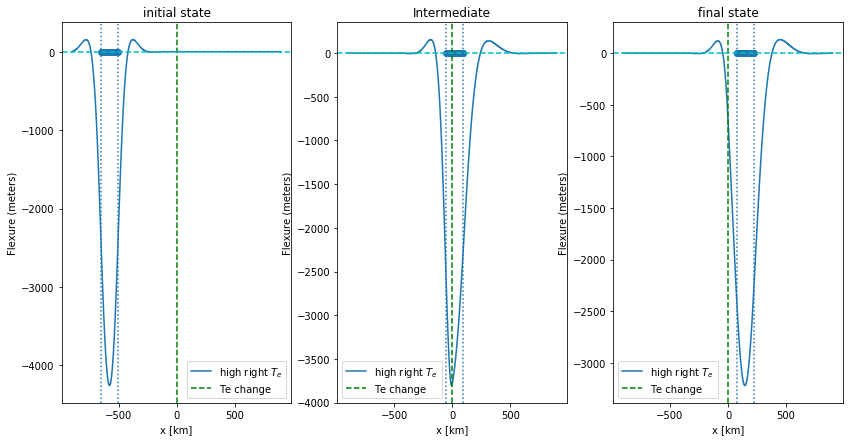

In [27]:
plt.figure(figsize=(14,7))

for t, load_point_right in enumerate(xDF_Right[[0, -6 ,-1]]):
    print(t, " / ", len(xDF_Right))
    loadLocations = np.arange(load_point_right-n_loadWidth, load_point_right,5000)
    loads = np.ones_like(loadLocations) * totalTopographicLoad / len(loadLocations)
    
    n_load = loadLocations

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, loads, loadLocations, n_halfWidth)
    
    plt.subplot(1,3,t+1)

    plt.plot(x/1000, w, label="high right $T_e$", hold=False)

    plt.axvline(x=0, linestyle="--", c='g', label="Te change")

    plt.scatter( x[loadLocations]/1000, (loads*0))
    plt.axvline( x=x[loadLocations[0]]/1000., linestyle=":" )
    plt.axvline( x=x[loadLocations[-1]]/1000., linestyle=":" )

    plt.axhline(y=0, linestyle="--", c='c')

    plt.xlabel("x [km]")
    plt.ylabel("Flexure (meters)")
    
    if(t==0):
        plt.title("initial state")
    elif (t==1):
        plt.title("Intermediate")
    else:
        plt.title("final state")
        
    plt.legend()

In [28]:
z_FB = np.empty_like( xDF_Right )
z_DF = np.empty_like( xDF_Right )
basinWidth_DF2FB = np.empty_like( xDF_Right )

makePlot = False

for t, load_point_right in enumerate(xDF_Right):
    print(t, " / ", len(xDF_Right))
    loadLocations = np.arange(load_point_right-n_loadWidth, load_point_right,1000)
    loads = np.ones_like(loadLocations) * totalTopographicLoad / len(loadLocations)
    
    n_load = np.array( [load_point_right] )

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, loads, loadLocations, n_halfWidth)
    
    n_FB = load_point_right + np.argmax( w[ load_point_right : ] )
    z_FB[t] = w[ n_FB ]
    z_DF[t] = w[load_point_right]
    basinWidth_DF2FB[t] = x[n_FB] - x[load_point_right]
    
    if(makePlot):
        plt.figure(figsize=(14,7))
        plt.plot(x/1000, w, label="high right $T_e$", hold=False)

        plt.axvline(x=0, linestyle="--", c='g', label="Te change")

        plt.axhline(z_DF[t], linestyle="--", c='b', hold=True)
        plt.axhline(z_FB[t], linestyle="--", c='orange', hold=True)

        plt.scatter((loadLocations-n_halfWidth)/1000, (loadLocations*0), hold=True)

        plt.axhline(y=0, linestyle="--", c='c')

        plt.xlabel("meters")
        plt.ylabel("negative flexure (meters)")
        plt.legend()

        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.01) # necessary to get the plot up.
    

(0, ' / ', 30)
(1, ' / ', 30)
(2, ' / ', 30)
(3, ' / ', 30)
(4, ' / ', 30)
(5, ' / ', 30)
(6, ' / ', 30)
(7, ' / ', 30)
(8, ' / ', 30)
(9, ' / ', 30)
(10, ' / ', 30)
(11, ' / ', 30)
(12, ' / ', 30)
(13, ' / ', 30)
(14, ' / ', 30)
(15, ' / ', 30)
(16, ' / ', 30)
(17, ' / ', 30)
(18, ' / ', 30)
(19, ' / ', 30)
(20, ' / ', 30)
(21, ' / ', 30)
(22, ' / ', 30)
(23, ' / ', 30)
(24, ' / ', 30)
(25, ' / ', 30)
(26, ' / ', 30)
(27, ' / ', 30)
(28, ' / ', 30)
(29, ' / ', 30)


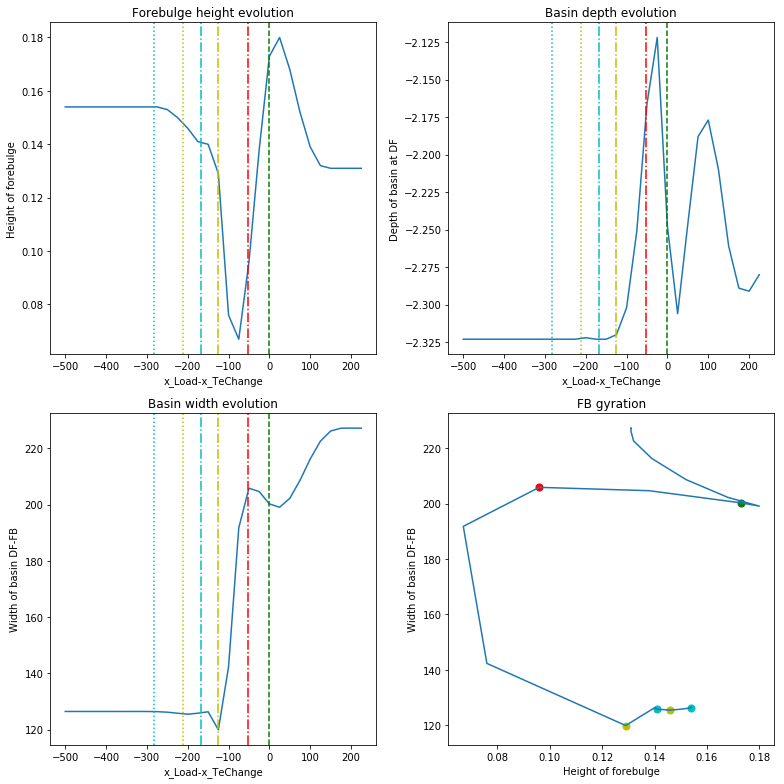

In [29]:
plt.figure(figsize=(11,11))

n_TeCrossingDF = (xDF_Right-n_halfWidth)==0
x_forebulge_low = np.pi*a_1
x_forebulge_high = np.pi*a_2
x_BM_low = 3*np.pi/4*a_1
x_BM_high = 3*np.pi/4*a_2

n_forebulge_low = np.argmin( ((xDF_Right-n_halfWidth)+x_forebulge_low)**2)
n_forebulge_high = np.argmin( ((xDF_Right-n_halfWidth)+x_forebulge_high)**2)
n_BM_low = np.argmin( ((xDF_Right-n_halfWidth)+x_BM_low)**2)
n_BM_high = np.argmin( ((xDF_Right-n_halfWidth)+x_BM_high)**2)
n_a1 = np.argmin( ((xDF_Right-n_halfWidth)+a_1)**2)


plt.subplot(3,2,1)
plt.plot((xDF_Right-n_halfWidth)/1000., z_FB/1000.)
plt.xlabel("x_Load-x_TeChange")
plt.ylabel("Height of forebulge")
plt.title("Forebulge height evolution")
plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")

plt.axvline(x=-x_BM_low/1000., c='y', linestyle="-.", label="Te Contast crosses initial basin margin")
plt.axvline(x=-x_forebulge_low/1000., c='c', linestyle="-.", label="Te Contast crosses initial FB")
plt.axvline(x=-a_1/1000., c='r', linestyle="-.", label="Te Contast crosses initial basin margin")
plt.axvline(x=-x_forebulge_high/1000., c='c', linestyle=":", label="Te Contast crosses final FB")
plt.axvline(x=-x_BM_high/1000., c='y', linestyle=":", label="Te Contast crosses final basin margin")

plt.subplot(3,2,2)
plt.plot((xDF_Right-n_halfWidth)/1000., z_DF/1000.)
plt.xlabel("x_Load-x_TeChange")
plt.ylabel("Depth of basin at DF")
plt.title("Basin depth evolution")
plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")

plt.axvline(x=-x_forebulge_low/1000., c='c', linestyle="-.", label="Te Contast crosses initial FB")
plt.axvline(x=-x_BM_low/1000., c='y', linestyle="-.", label="Te Contast crosses initial basin margin")
plt.axvline(x=-x_forebulge_high/1000., c='c', linestyle=":", label="Te Contast crosses final FB")
plt.axvline(x=-x_BM_high/1000., c='y', linestyle=":", label="Te Contast crosses final basin margin")
plt.axvline(x=-a_1/1000., c='r', linestyle="-.", label="Te Contast crosses initial basin margin")

plt.subplot(3,2,3)
plt.plot((xDF_Right-n_halfWidth)/1000., basinWidth_DF2FB/1000.)
plt.xlabel("x_Load-x_TeChange")
plt.ylabel("Width of basin DF-FB")
plt.title("Basin width evolution")
plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")

plt.axvline(x=-x_forebulge_low/1000., c='c', linestyle="-.", label="Te Contast crosses initial FB")
plt.axvline(x=-x_BM_low/1000, c='y', linestyle="-.", label="Te Contast crosses initial basin margin")
plt.axvline(x=-x_forebulge_high/1000., c='c', linestyle=":", label="Te Contast crosses final FB")
plt.axvline(x=-x_BM_high/1000., c='y', linestyle=":", label="Te Contast crosses final basin margin")
plt.axvline(x=-a_1/1000., c='r', linestyle="-.", label="Te Contast crosses initial basin margin")

plt.subplot(3,2,4)
plt.plot( z_FB/1000., basinWidth_DF2FB/1000.)
plt.scatter( z_FB[n_TeCrossingDF]/1000., basinWidth_DF2FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Height of forebulge")
plt.ylabel("Width of basin DF-FB")
plt.title("FB gyration")

plt.scatter(z_FB[n_forebulge_low]/1000., basinWidth_DF2FB[n_forebulge_low]/1000., c="c", s=50)
plt.scatter(z_FB[n_forebulge_high]/1000., basinWidth_DF2FB[n_forebulge_high]/1000., c="c", s=50)
plt.scatter(z_FB[n_BM_low]/1000., basinWidth_DF2FB[n_BM_low]/1000., c="y", s=50)
plt.scatter(z_FB[n_BM_high]/1000., basinWidth_DF2FB[n_BM_high]/1000., c="y", s=50)
plt.scatter(z_FB[n_a1]/1000., basinWidth_DF2FB[n_a1]/1000., c="r", s=50)

plt.subplot(3,2,5)
plt.plot( z_DF/1000., basinWidth_DF2FB/1000.)
plt.scatter( z_DF[n_TeCrossingDF]/1000., basinWidth_DF2FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Height of forebulge")
plt.ylabel("Width of basin DF-FB")
plt.title("FB gyration")

plt.scatter(z_DF[n_forebulge_low]/1000., basinWidth_DF2FB[n_forebulge_low]/1000., c="c", s=50)
plt.scatter(z_DF[n_forebulge_high]/1000., basinWidth_DF2FB[n_forebulge_high]/1000., c="c", s=50)
plt.scatter(z_DF[n_BM_low]/1000., basinWidth_DF2FB[n_BM_low]/1000., c="y", s=50)
plt.scatter(z_DF[n_BM_high]/1000., basinWidth_DF2FB[n_BM_high]/1000., c="y", s=50)
plt.scatter(z_DF[n_a1]/1000., basinWidth_DF2FB[n_a1]/1000., c="r", s=50)


plt.tight_layout()

## Track Stratigraphy With Distributed Load

In [30]:
D_1 = 4.6e22 #flexural regidity (N meters), weak plate
D_2 = 3.7e23 #flexural regidity (N meters), strong plate

#density of sediment
rho_s = 3000 #kg/m3
rho_w = 1000 #kg/m3
rho_m = 3300 #kg/m3
g = 9.8 #ms-2
h_s = 2000 #meters, load thickness
a_1 = (4*D_1/( g * (rho_m - rho_w)))**0.25 #flexural parameter alpha
a_2 = (4*D_2/( g * (rho_m - rho_w)))**0.25

n_halfWidth = 900000

totalTopographicLoad = 1.5e13
n_loadWidth = 150000

contact_load = np.array( [8.8e12] )
nodesMigratedInOneTimestep = 15000   # [nodes/timestep]
xDF_Right = n_halfWidth + np.arange(-500000, 250000, nodesMigratedInOneTimestep)
xDF_Left = xDF_Right - n_loadWidth

loadThickness = totalTopographicLoad / ( n_loadWidth * rho_s * g)
print(loadThickness)
#loadLocations = np.flip(loadLocations, axis=0)

3401.36054422


#### Position of Te and DFs with time

Text(0,0.5,'Position of deformation fronts [nodes]')

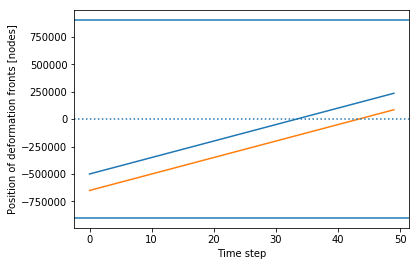

In [31]:
plt.plot(xDF_Right-n_halfWidth)
plt.plot(xDF_Left-n_halfWidth)
plt.axhline(y=n_halfWidth)
plt.axhline(y=-n_halfWidth)
plt.axhline(y=0, linestyle=":")

plt.xlabel("Time step")
plt.ylabel("Position of deformation fronts [nodes]")

In [32]:
z_FB = np.empty_like( xDF_Right )
z_DF = np.empty_like( xDF_Right )
n_BM = np.empty_like( xDF_Right )
n_FB = np.empty_like( xDF_Right )

basinWidth_DF2FB = np.empty_like( xDF_Right )
basinWidth_DF2BM = np.empty_like( xDF_Right )

makePlot = False

for t, load_point_right in enumerate(xDF_Right):
    print(t, " / ", len(xDF_Right))
    loadLocations = np.arange(load_point_right-n_loadWidth, load_point_right,1000)
    loads = np.ones_like(loadLocations) * totalTopographicLoad / len(loadLocations)
    
    n_load = np.array( [load_point_right] )

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, loads, loadLocations, n_halfWidth)
    
    n_FB[t] = load_point_right + np.argmax( w[ load_point_right : ] )
    n_BM[t] = load_point_right + np.argmin( w[ load_point_right : n_FB[t] ]**2 )
    z_FB[t] = w[ n_FB[t] ]
    z_DF[t] = w[load_point_right]
    basinWidth_DF2FB[t] = x[ n_FB[t] ] - x[load_point_right]
    basinWidth_DF2BM[t] = x[ n_BM[t] ] - x[load_point_right]
    
    if(t==0):
        flexuralProfileHistory = w.T
    else:
        flexuralProfileHistory = np.vstack( ( flexuralProfileHistory, w.T) )
    
    if(makePlot):
        plt.figure(figsize=(14,7))
        plt.plot(x/1000, w, label="high right $T_e$", hold=False)

        plt.axvline(x=0, linestyle="--", c='g', label="Te change")

        plt.axhline(z_DF[t], linestyle="--", c='b', hold=True)
        plt.axhline(z_FB[t], linestyle="--", c='orange', hold=True)

        plt.scatter((loadLocations-n_halfWidth)/1000, (loadLocations*0), hold=True)

        plt.axhline(y=0, linestyle="--", c='c')

        plt.xlabel("meters")
        plt.ylabel("negative flexure (meters)")
        plt.legend()

        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.01) # necessary to get the plot up.

(0, ' / ', 50)
(1, ' / ', 50)
(2, ' / ', 50)
(3, ' / ', 50)
(4, ' / ', 50)
(5, ' / ', 50)
(6, ' / ', 50)
(7, ' / ', 50)
(8, ' / ', 50)
(9, ' / ', 50)
(10, ' / ', 50)
(11, ' / ', 50)
(12, ' / ', 50)
(13, ' / ', 50)
(14, ' / ', 50)
(15, ' / ', 50)
(16, ' / ', 50)
(17, ' / ', 50)
(18, ' / ', 50)
(19, ' / ', 50)
(20, ' / ', 50)
(21, ' / ', 50)
(22, ' / ', 50)
(23, ' / ', 50)
(24, ' / ', 50)
(25, ' / ', 50)
(26, ' / ', 50)
(27, ' / ', 50)
(28, ' / ', 50)
(29, ' / ', 50)
(30, ' / ', 50)
(31, ' / ', 50)
(32, ' / ', 50)
(33, ' / ', 50)
(34, ' / ', 50)
(35, ' / ', 50)
(36, ' / ', 50)
(37, ' / ', 50)
(38, ' / ', 50)
(39, ' / ', 50)
(40, ' / ', 50)
(41, ' / ', 50)
(42, ' / ', 50)
(43, ' / ', 50)
(44, ' / ', 50)
(45, ' / ', 50)
(46, ' / ', 50)
(47, ' / ', 50)
(48, ' / ', 50)
(49, ' / ', 50)


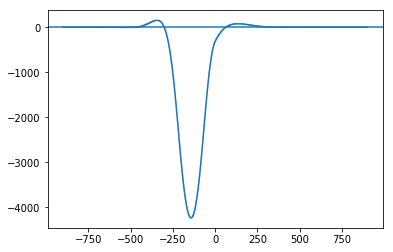

In [33]:
plt.plot(x/1000, flexuralProfileHistory[29])
plt.axhline(0)

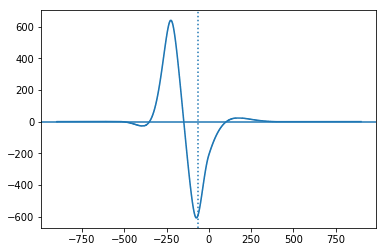

In [34]:
plt.plot(x/1000, flexuralProfileHistory[29]-flexuralProfileHistory[28])
plt.axhline(0)
plt.axvline(x= (xDF_Right[29]-n_halfWidth)/1000, linestyle=":")

In [35]:
accommodationGeneration = flexuralProfileHistory[1:]-flexuralProfileHistory[:-1]
accommodationGeneration[accommodationGeneration>0] = 0

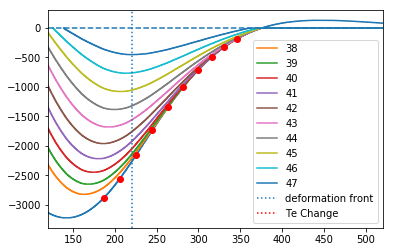

In [39]:
for t in range(0,49):
    plt.plot(x/1000, flexuralProfileHistory[t], hold=False)

    n_start = t - 10
    if( n_start < 0 ):
        n_start = 0
        
    for n in range(n_start, t):
        stratigraphicLayer = flexuralProfileHistory[t] - np.sum( accommodationGeneration[0:n-1], axis=0)
        nStrat = (stratigraphicLayer<0)
        plt.plot(x[nStrat]/1000, stratigraphicLayer[nStrat] , label=str(n) )
        plt.plot((n_BM[n+1]-n_halfWidth)/1000, flexuralProfileHistory[t][n_BM[n+1]], 'ro' )

    plt.axvline(x=(xDF_Right[t]-n_halfWidth)/1000 , linestyle=":", label="deformation front")
    plt.axvline(x=0 , c='r', linestyle=":", label="Te Change")
    #plt.axvline(x=(n_BM[t]-n_halfWidth)/1000 , c='r', linestyle=":", label="Te Change")

    plt.axhline(0, linestyle="--")

    plt.xlim((xDF_Right[t]-n_halfWidth-100000)/1000,(xDF_Right[t]-n_halfWidth+300000)/1000)
    plt.legend()
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1) # necessary to get the plot up.

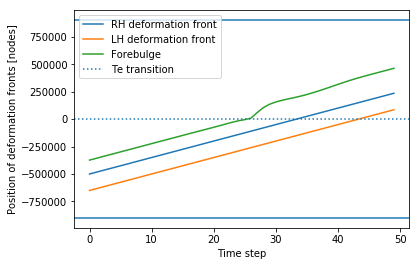

In [174]:
plt.plot(xDF_Right-n_halfWidth, label="RH deformation front")
plt.plot(xDF_Left-n_halfWidth, label="LH deformation front")
plt.plot(n_FB-n_halfWidth, label="Forebulge")
plt.axhline(y=n_halfWidth)
plt.axhline(y=-n_halfWidth)
plt.axhline(y=0, linestyle=":", label="Te transition")

plt.xlabel("Time step")
plt.ylabel("Position of deformation fronts [nodes]")
plt.legend()

## Unroofing of final stratigraphy

In [175]:
z_FB_unroof = np.empty_like( xDF_Right )
z_DF_unroof = np.empty_like( xDF_Right )
n_FB_unroof = np.empty_like( xDF_Right )

basinWidth_DF2FB = np.empty_like( xDF_Right )

makePlot = False

fractionOfTopoRemaining = np.arange(1,0.5,-0.1)

for t, loadFraction in enumerate(fractionOfTopoRemaining):
    print(t, " / ", len(fractionOfTopoRemaining))
    loads = np.ones_like(loadLocations) * totalTopographicLoad / len(loadLocations) * loadFraction
    
    n_load = np.array( [load_point_right] )

    x, w, load = Plate_Flexure_MN(a_1, a_2, D_1, D_2, loads, loadLocations, n_halfWidth)
    
    n_FB_unroof[t] = load_point_right + np.argmax( w[ load_point_right : ] )
    z_FB_unroof[t] = w[ n_FB_unroof[t] ]
    z_DF_unroof[t] = w[load_point_right]
    basinWidth_DF2FB[t] = x[ n_FB_unroof[t] ] - x[load_point_right]
    
    if(t==0):
        flexuralProfileHistory_unroof = w.T
    else:
        flexuralProfileHistory_unroof = np.vstack( ( flexuralProfileHistory_unroof, w.T) )

(0, ' / ', 5)
(1, ' / ', 5)
(2, ' / ', 5)
(3, ' / ', 5)
(4, ' / ', 5)


In [181]:
snapshot = 4
plt.plot(x/1000,flexuralProfileHistory_unroof[snapshot])

t=49
for n in range(t-15,t):
    stratigraphicLayer = flexuralProfileHistory_unroof[snapshot] - np.sum( accommodationGeneration[0:n], axis=0)
    #nStrat = (stratigraphicLayer<0)
    plt.plot(x/1000, stratigraphicLayer , label=str(n) )
    #plt.plot(x[nStrat]/1000, stratigraphicLayer[nStrat] , label=str(n) )
    
plt.axhline(0, linestyle="--")
plt.xlim((xDF_Right[t]-n_halfWidth-100000)/1000,(xDF_Right[t]-n_halfWidth+300000)/1000)
plt.axvline(x=(xDF_Right[t]-n_halfWidth)/1000 , linestyle=":", label="deformation front")
plt.axvline(x=0 , c='r', linestyle=":", label="Te Change")



IndexError: index 5 is out of bounds for axis 0 with size 5

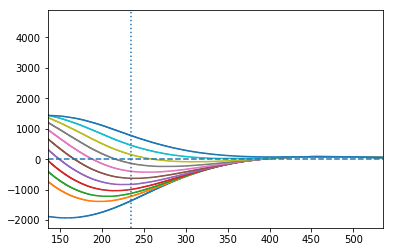

In [170]:
snapshot = 4
plt.plot(x/1000,flexuralProfileHistory_unroof[snapshot])

t=49
for n in range(t-10,t):
    stratigraphicLayer = flexuralProfileHistory_unroof[snapshot] - np.sum( accommodationGeneration[0:n], axis=0)
    #nStrat = (stratigraphicLayer<0)
    plt.plot(x/1000, stratigraphicLayer , label=str(n) )
    #plt.plot(x[nStrat]/1000, stratigraphicLayer[nStrat] , label=str(n) )
    
plt.axhline(0, linestyle="--")
plt.xlim((xDF_Right[t]-n_halfWidth-100000)/1000,(xDF_Right[t]-n_halfWidth+300000)/1000)
plt.axvline(x=(xDF_Right[t]-n_halfWidth)/1000 , linestyle=":", label="deformation front")
plt.axvline(x=0 , c='r', linestyle=":", label="Te Change")

